In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 12:14:38.271607
File: machine_learning_experiment04
Experiment Number: 4


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 1029933563


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment04.ipynb' is assigned to device: cuda:2 with seed 1029933563.


Experiment number: 4 | Seed number: 1029933563
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 12:14:39,059] A new study created in memory with name: no-name-ccfbedb0-2951-4c90-a80b-cd9f91032040


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:39,766] Trial 0 finished with value: 0.79120745586911 and parameters: {'threshold': '0.5*mean', 'max_features': 350, 'norm_order': 1, 'n_estimators': 79, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features_rf': 0.6206571343332717}. Best is trial 0 with value: 0.79120745586911.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:40,874] Trial 1 finished with value: 0.8632290362953691 and parameters: {'threshold': '1.5*mean', 'max_features': 589, 'norm_order': 1, 'n_estimators': 206, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features_rf': 0.5548346488004212}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:41,646] Trial 2 finished with value: 0.8450653594771241 and parameters: {'threshold': '0.5*mean', 'max_features': 980, 'norm_order': 2, 'n_estimators': 96, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features_rf': 0.6943173131728126}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:43,030] Trial 3 finished with value: 0.8296145124716553 and parameters: {'threshold': '0.5*mean', 'max_features': 822, 'norm_order': 1, 'n_estimators': 215, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features_rf': 0.7570483274687118}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:44,139] Trial 4 finished with value: 0.828904428904429 and parameters: {'threshold': 'mean', 'max_features': 615, 'norm_order': 2, 'n_estimators': 172, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features_rf': 0.7019400716806035}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:46,394] Trial 5 finished with value: 0.803578597235763 and parameters: {'threshold': 'very_low', 'max_features': 546, 'norm_order': 1, 'n_estimators': 272, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features_rf': 0.5244518971600804}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:48,041] Trial 6 finished with value: 0.7833047455688966 and parameters: {'threshold': 'median', 'max_features': 762, 'norm_order': 2, 'n_estimators': 127, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features_rf': 0.679692989668276}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:49,372] Trial 7 finished with value: 0.8501357466063348 and parameters: {'threshold': '1.5*mean', 'max_features': 895, 'norm_order': 2, 'n_estimators': 242, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features_rf': 0.5553299224729569}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:51,660] Trial 8 finished with value: 0.8251851851851851 and parameters: {'threshold': 'median', 'max_features': 889, 'norm_order': 1, 'n_estimators': 144, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features_rf': 0.7475898692433689}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:52,751] Trial 9 finished with value: 0.8300768693221524 and parameters: {'threshold': '1.5*mean', 'max_features': 272, 'norm_order': 2, 'n_estimators': 83, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features_rf': 0.9699382470303475}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:54,498] Trial 10 finished with value: 0.8325381334489989 and parameters: {'threshold': '1.5*mean', 'max_features': 24, 'norm_order': 1, 'n_estimators': 292, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.8721754155484479}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:55,890] Trial 11 finished with value: 0.823529411764706 and parameters: {'threshold': '1.5*mean', 'max_features': 736, 'norm_order': 2, 'n_estimators': 212, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features_rf': 0.5018880811042982}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:57,891] Trial 12 finished with value: 0.8472722422302255 and parameters: {'threshold': '1.5*mean', 'max_features': 396, 'norm_order': 2, 'n_estimators': 244, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features_rf': 0.5774508444302024}. Best is trial 1 with value: 0.8632290362953691.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:14:59,428] Trial 13 finished with value: 0.8734160330798986 and parameters: {'threshold': '1.5*mean', 'max_features': 1038, 'norm_order': 1, 'n_estimators': 210, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.588980157185506}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:02,402] Trial 14 finished with value: 0.8217362158538629 and parameters: {'threshold': 'very_low', 'max_features': 1013, 'norm_order': 1, 'n_estimators': 186, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6229273603540821}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:04,104] Trial 15 finished with value: 0.8548445019033254 and parameters: {'threshold': 'mean', 'max_features': 146, 'norm_order': 1, 'n_estimators': 178, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.8285162757162522}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:06,125] Trial 16 finished with value: 0.8668907563025211 and parameters: {'threshold': '1.5*mean', 'max_features': 685, 'norm_order': 1, 'n_estimators': 216, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.6197640085508785}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:07,868] Trial 17 finished with value: 0.8668907563025211 and parameters: {'threshold': '1.5*mean', 'max_features': 682, 'norm_order': 1, 'n_estimators': 244, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features_rf': 0.621583428675318}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:09,390] Trial 18 finished with value: 0.8715032679738561 and parameters: {'threshold': '1.5*mean', 'max_features': 476, 'norm_order': 1, 'n_estimators': 146, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.6579715550936661}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:10,610] Trial 19 finished with value: 0.8071558836300478 and parameters: {'threshold': 'median', 'max_features': 501, 'norm_order': 1, 'n_estimators': 51, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features_rf': 0.7981777337242832}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:12,748] Trial 20 finished with value: 0.8156408070474567 and parameters: {'threshold': 'very_low', 'max_features': 441, 'norm_order': 1, 'n_estimators': 136, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features_rf': 0.6766865125403014}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:14,114] Trial 21 finished with value: 0.8658343337334934 and parameters: {'threshold': '1.5*mean', 'max_features': 282, 'norm_order': 1, 'n_estimators': 160, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.5975480346090764}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:16,105] Trial 22 finished with value: 0.8660130718954248 and parameters: {'threshold': '1.5*mean', 'max_features': 476, 'norm_order': 1, 'n_estimators': 200, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.6542722264098755}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:17,730] Trial 23 finished with value: 0.8516073095905029 and parameters: {'threshold': '1.5*mean', 'max_features': 652, 'norm_order': 1, 'n_estimators': 229, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features_rf': 0.7315575414526171}. Best is trial 13 with value: 0.8734160330798986.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:19,658] Trial 24 finished with value: 0.8772175536881419 and parameters: {'threshold': '1.5*mean', 'max_features': 913, 'norm_order': 1, 'n_estimators': 264, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6516999549754293}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:21,424] Trial 25 finished with value: 0.8723809523809524 and parameters: {'threshold': 'mean', 'max_features': 941, 'norm_order': 1, 'n_estimators': 274, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6551618400204857}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:23,403] Trial 26 finished with value: 0.8568253968253968 and parameters: {'threshold': 'mean', 'max_features': 1033, 'norm_order': 1, 'n_estimators': 273, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features_rf': 0.5736558575189104}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:25,516] Trial 27 finished with value: 0.8315736551030669 and parameters: {'threshold': 'mean', 'max_features': 924, 'norm_order': 1, 'n_estimators': 298, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features_rf': 0.7809039785224026}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:27,680] Trial 28 finished with value: 0.8587755102040816 and parameters: {'threshold': 'mean', 'max_features': 833, 'norm_order': 1, 'n_estimators': 271, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.7123988266857795}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:29,840] Trial 29 finished with value: 0.8467908902691512 and parameters: {'threshold': '0.5*mean', 'max_features': 958, 'norm_order': 1, 'n_estimators': 257, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features_rf': 0.6521992981799841}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:32,050] Trial 30 finished with value: 0.8332811595852663 and parameters: {'threshold': 'mean', 'max_features': 811, 'norm_order': 1, 'n_estimators': 288, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features_rf': 0.5273470798142121}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:33,064] Trial 31 finished with value: 0.8660130718954248 and parameters: {'threshold': '1.5*mean', 'max_features': 882, 'norm_order': 1, 'n_estimators': 122, 'max_depth': 29, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6488689495621348}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:34,588] Trial 32 finished with value: 0.8666442026892591 and parameters: {'threshold': '1.5*mean', 'max_features': 1028, 'norm_order': 1, 'n_estimators': 156, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features_rf': 0.6033484432703337}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:36,272] Trial 33 finished with value: 0.8479349186483104 and parameters: {'threshold': '0.5*mean', 'max_features': 949, 'norm_order': 1, 'n_estimators': 197, 'max_depth': 27, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features_rf': 0.6547901110073275}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:37,499] Trial 34 finished with value: 0.8491918506533048 and parameters: {'threshold': '1.5*mean', 'max_features': 560, 'norm_order': 1, 'n_estimators': 109, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features_rf': 0.7265993226158889}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:39,652] Trial 35 finished with value: 0.8728431372549018 and parameters: {'threshold': 'mean', 'max_features': 358, 'norm_order': 1, 'n_estimators': 258, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features_rf': 0.6918801914817854}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:41,557] Trial 36 finished with value: 0.859047619047619 and parameters: {'threshold': 'mean', 'max_features': 339, 'norm_order': 1, 'n_estimators': 264, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features_rf': 0.6896036971455332}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:43,408] Trial 37 finished with value: 0.8511111111111113 and parameters: {'threshold': 'mean', 'max_features': 977, 'norm_order': 1, 'n_estimators': 229, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features_rf': 0.5927253258348718}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:45,494] Trial 38 finished with value: 0.868764172335601 and parameters: {'threshold': 'mean', 'max_features': 846, 'norm_order': 1, 'n_estimators': 280, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features_rf': 0.5430679816403281}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:47,470] Trial 39 finished with value: 0.8408547008547008 and parameters: {'threshold': 'mean', 'max_features': 764, 'norm_order': 1, 'n_estimators': 258, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features_rf': 0.7781598386959238}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:49,826] Trial 40 finished with value: 0.8375510204081632 and parameters: {'threshold': 'median', 'max_features': 215, 'norm_order': 2, 'n_estimators': 237, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features_rf': 0.7065693977731732}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:52,947] Trial 41 finished with value: 0.847536231884058 and parameters: {'threshold': 'very_low', 'max_features': 394, 'norm_order': 1, 'n_estimators': 249, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.6775308721403583}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:54,886] Trial 42 finished with value: 0.8403531625416124 and parameters: {'threshold': '0.5*mean', 'max_features': 440, 'norm_order': 1, 'n_estimators': 225, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6432139201192068}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:56,308] Trial 43 finished with value: 0.8111706120814773 and parameters: {'threshold': '1.5*mean', 'max_features': 587, 'norm_order': 1, 'n_estimators': 285, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features_rf': 0.6283518761192427}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:58,000] Trial 44 finished with value: 0.8565532879818595 and parameters: {'threshold': 'mean', 'max_features': 329, 'norm_order': 1, 'n_estimators': 157, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.6699097142801018}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:15:59,722] Trial 45 finished with value: 0.8233333333333334 and parameters: {'threshold': '1.5*mean', 'max_features': 898, 'norm_order': 1, 'n_estimators': 187, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features_rf': 0.9848152273551032}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:16:01,871] Trial 46 finished with value: 0.8398692810457516 and parameters: {'threshold': 'median', 'max_features': 148, 'norm_order': 1, 'n_estimators': 256, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features_rf': 0.744869532988658}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:16:04,304] Trial 47 finished with value: 0.8701587301587302 and parameters: {'threshold': '1.5*mean', 'max_features': 537, 'norm_order': 2, 'n_estimators': 268, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features_rf': 0.5697242855239145}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:16:06,963] Trial 48 finished with value: 0.8229610684853652 and parameters: {'threshold': 'very_low', 'max_features': 997, 'norm_order': 1, 'n_estimators': 170, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.9058788327658993}. Best is trial 24 with value: 0.8772175536881419.


Seed in the model 1029933563 on Device cuda:2


[I 2024-12-05 12:16:08,324] Trial 49 finished with value: 0.8517006802721089 and parameters: {'threshold': 'mean', 'max_features': 783, 'norm_order': 1, 'n_estimators': 214, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features_rf': 0.7000358665064326}. Best is trial 24 with value: 0.8772175536881419.


Best Parameters: {'threshold': '1.5*mean', 'max_features': 913, 'norm_order': 1, 'n_estimators': 264, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features_rf': 0.6516999549754293}

Test Metrics:
ROC AUC: 0.8350168350168351
Accuracy: 0.7701149425287356
F1 Score: 0.6551724137931034
Confusion Matrix:
[[48  6]
 [14 19]]


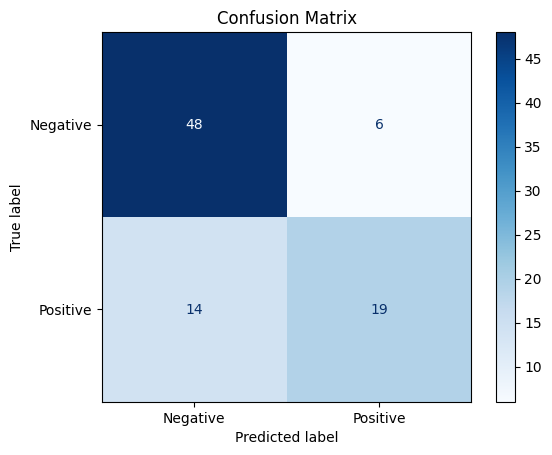


Classification Report:
              precision    recall  f1-score   support

    Negative       0.77      0.89      0.83        54
    Positive       0.76      0.58      0.66        33

    accuracy                           0.77        87
   macro avg       0.77      0.73      0.74        87
weighted avg       0.77      0.77      0.76        87

Number of selected features: 68


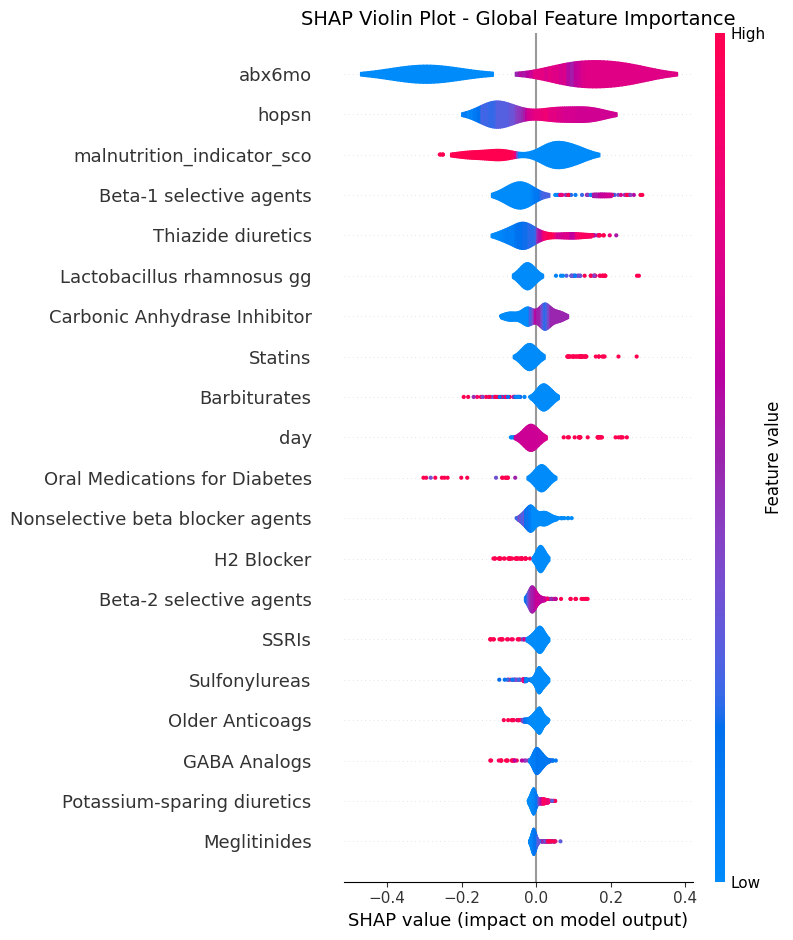

No overlap bacteria found.


In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define RandomForest parameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    max_features_rf = trial.suggest_float("max_features_rf", 0.5, 1.0)  # Renamed parameter

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

        # Train RandomForestClassifier
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features_rf,  # Use new name here
            random_state=seed,
            class_weight={0: 1.0, 1: scale_pos_weight},  # Handle class imbalance
        )
        model.fit(X_train_fold, y_train_fold)

        # Validation predictions
        y_val_pred = model.predict_proba(X_val_fold)[:, 1]  # Probability of positive class
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)  # Binary classification
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))

    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age",]

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=50)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=seed,
        tree_method=gpu_device,
        device=device
    ),
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],  # Corrected key
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features_rf"],  # Use the correct key
    random_state=seed,
    class_weight={0: 1.0, 1: scale_pos_weight},  # Handle class imbalance
)
final_model.fit(X_train_selected, y_train)

# Predictions and Evaluation
y_test_pred = final_model.predict_proba(X_test_selected)[:, 1]  # Probability of positive class
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Evaluate Model Performance
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in range(X_train_selected.shape[1])]
# Truncate each feature name to a maximum of 30 characters
selected_feature_names = [
    feature[:30] if len(feature) > 40 else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Step 3: Aggregate SHAP values to mimic XGBoost
# For binary classification: take the difference between class 1 and class 0
shap_values_aggregated = shap_values.values[:, :, 1] - shap_values.values[:, :, 0]

# Step 4: Plot SHAP summary
plt.figure(figsize=(20, 10))  # Wide plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

shap.summary_plot(
    shap_values_aggregated,  # Correct SHAP values
    X_train_selected,  # Input data aligned with SHAP values
    feature_names=selected_feature_names,  # Ensure feature names align
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot style
)

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)
bacteria_fount

No overlap bacteria found.


set()

In [16]:
auc

np.float64(0.8350168350168351)

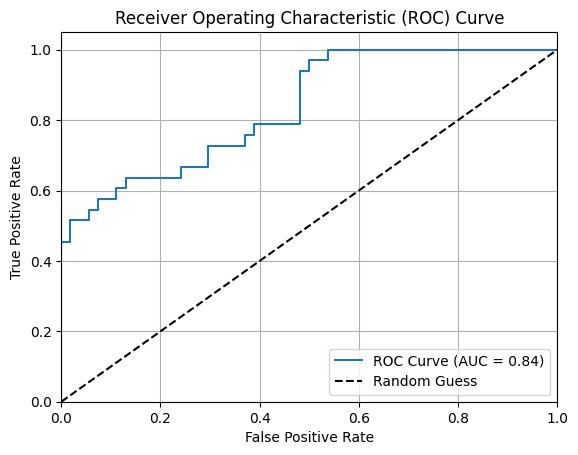

In [17]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [18]:
accuracy

0.7701149425287356

In [19]:
f1

np.float64(0.6551724137931034)

In [20]:
conf_matrix

array([[48,  6],
       [14, 19]])

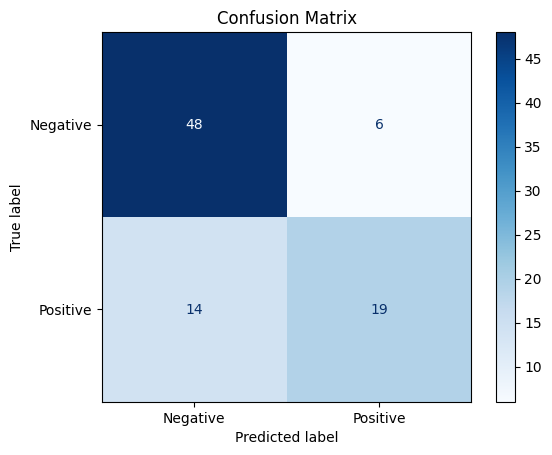

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [22]:
measures = ["randomforest", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,randomforest,1029933563,4,0.770115,0.835017,0.655172


In [23]:
output_path = "output"
measures_path = f"{output_path}{os.sep}randomforest_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/randomforest_experiment04_measures.csv'

In [24]:
measures_df.to_csv(measures_path, index=False)